In [1]:
from koopmanlib.param_solver import KoopmanParametricDLSolver, KoopmanLinearDLSolver, KoopmanBilinearDLSolver
from koopmanlib.dictionary import PsiNN
from tensorflow.keras.optimizers import Adam
import json
import sys
import numpy as np
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from tqdm.keras import TqdmCallback


2024-03-07 15:11:29.543232: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/guoyue/Learning-Parametric-Koopman-Decompositions/pknn_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:


config_file = 'config_vdpm.json'
with open(config_file, 'r') as f:
    config = json.load(f)

data_path = config['data_settings']['data_path']
weights_path = config['nn_settings']['weights_path']

n_psi_train = config['nn_settings']['n_psi_train']
mu_list = config['data_settings']['mu']

mu = mu_list[0]
target_dim = 2
param_dim = 1

n_psi = 1 + target_dim + n_psi_train

dict_layer_size = config['nn_settings']['dict_layer_size']
K_layer_size_list = config['nn_settings']['K_layer_size']

linear_epochs = config['nn_settings']['linear_epochs']
bilinear_epochs = config['nn_settings']['bilinear_epochs']
pknn_epochs = config['nn_settings']['pknn_epochs']

2024-03-07 15:14:49.255254: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-07 15:14:49.255319: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-03-07 15:14:49.255327: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-03-07 15:14:49.255561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.239.6
2024-03-07 15:14:49.255598: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.239.6
2024-03-07 15:14:49.255604: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.239.6
2024-03-07 15:14:49.256291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfo

In [8]:
# Load data
dict_data = np.load(os.path.join(
    data_path, 'vdpm_data_mu_'+str(mu)+'.npy'), allow_pickle=True)
data_x = dict_data[()]['data_x']
data_y = dict_data[()]['data_y']
data_u = dict_data[()]['data_u']

In [9]:
data_x.shape

(25000, 2)

In [ ]:

def load_data_and_train_models(mu, K_layer_size):

    # Load data
    dict_data = np.load(os.path.join(
        data_path, 'vdpm_data_mu_'+str(mu)+'.npy'), allow_pickle=True)

    data_x = dict_data[()]['data_x']
    data_y = dict_data[()]['data_y']
    data_u = dict_data[()]['data_u']

    # PK-NN
    dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)
    from koopmanlib.K_structure import Model_K_u_Layer, Model_K_u_Layer_One

    model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, 
                                    n_psi=n_psi,
                                    activation='tanh')

    solver_pk = KoopmanParametricDLSolver(
        target_dim=target_dim, 
        param_dim=param_dim, 
        n_psi=n_psi, 
        dic=dic_pk, 
        model_K_u=model_K_u)

    model_pk, model_K_u_pred_pk = solver_pk.generate_model()

    model_pk.summary()

    zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

    model_pk.compile(optimizer=Adam(0.001),
                    loss='mse')
    


    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                        factor=0.1,
                                                        patience=100,
                                                        verbose=0,
                                                        mode='auto',
                                                        min_delta=1e-4,
                                                        cooldown=0,
                                                        min_lr=1e-6)

    # Define the early stopping criteria
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    min_delta=1e-9,
                                                    patience=50, 
                                                    verbose=1, 
                                                    mode='auto')

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(
            weights_path, 'model_pk_vdpm_mu_'+str(mu)+'.h5'),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            mode='min',
            save_freq='epoch')
    
    # Define the TqdmCallback for progress bar
    tqdm_callback = TqdmCallback(verbose=1)

    # Add early_stopping to the list of callbacks
    callbacks = [lr_callback, es_callback, checkpoint_callback, tqdm_callback]

    history = model_pk.fit(x=[data_x, data_y, data_u],
                    y=zeros_data_y_train,
                    validation_split=0.2,
                    epochs=pknn_epochs,
                    batch_size=200,
                    callbacks=callbacks,
                    verbose=0)

    
    # # Linear Model: Dynamics is $Az +Bu$

    dic_linear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

    solver_linear = KoopmanLinearDLSolver(
        dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

    model_linear = solver_linear.build_model()

    solver_linear.build(model_linear,
                        data_x,
                        data_u,
                        data_y,
                        zeros_data_y_train,
                        epochs=linear_epochs,
                        batch_size=200,
                        lr=0.0001,
                        lr_patience=100,
                        lr_decay_factor=0.1,
                        lr_min=1e-6,
                        es_patience=50,
                        es_min_delta=1e-9,
                        filepath=os.path.join(
                            weights_path, 'model_linear_vdpm_mu_'+str(mu)+'.h5'))



    # # Bilinear Model: Dynamics is $Az + \sum_{i=1}^{N_{u}}B_{i}zu_{i}$

    dic_bilinear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

    solver_bilinear = KoopmanBilinearDLSolver(
        dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

    model_bilinear = solver_bilinear.build_model()

    solver_bilinear.build(model_bilinear,
                            data_x,
                            data_u,
                            data_y,
                            zeros_data_y_train,
                            epochs=bilinear_epochs,
                            batch_size=200,
                            lr=0.0001,
                            lr_patience=100,
                            lr_decay_factor=0.1,
                            lr_min=1e-6,
                            es_patience=50,
                            es_min_delta=1e-9,
                            filepath=os.path.join(
                                weights_path, 'model_bilinear_vdpm_mu_'+str(mu)+'.h5'))


for mu, K_layer_size in zip(mu_list, K_layer_size_list):
    load_data_and_train_models(mu, K_layer_size)
    print('mu = ', mu, 'done')
    print('K_layer_size = ', K_layer_size, 'done')


In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

2024-03-06 18:42:55.798984: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
import json
import sys

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [6]:
import matplotlib.pyplot as plt

In [7]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.target import VanderPolMathieuTarget
from koopmanlib.param_solver import KoopmanParametricDLSolver, KoopmanLinearDLSolver, KoopmanBilinearDLSolver

In [8]:
config_file = 'config_vdpm.json'

with open(config_file, 'r') as f:
    config = json.load(f)

data_path = config['data_settings']['data_path']
weights_path = config['nn_settings']['weights_path']

n_traj = config['data_settings']['n_traj']
traj_len = config['data_settings']['traj_len']
mu = config['data_settings']['mu'][0]

n_psi_train = config['nn_settings']['n_psi_train']
dict_layer_size = config['nn_settings']['dict_layer_size']
K_layer_size = config['nn_settings']['K_layer_size'][0]

In [9]:
dict_layer_size

[32, 32]

In [10]:
print('mu', mu)
print('K_layer_size', K_layer_size)

mu 0
K_layer_size [32]


In [11]:
target_dim = 2
param_dim = 1

n_psi = 1 + target_dim + n_psi_train

In [12]:
# Set parameters in the vdpm equation.
k1, k2, k4, w0 = 2,2,1,1

In [13]:
vdp_mathieu = VanderPolMathieuTarget(mu=mu,
                                     dim=target_dim,
                                     param_dim=param_dim, 
                                     k1=k1,
                                    k2=k2,
                                    k4=k4,
                                    w0=w0)

In [14]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [15]:
from koopmanlib.K_structure import Model_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, 
                                n_psi=n_psi,
                                activation='tanh')

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, 
    param_dim=param_dim, 
    n_psi=n_psi, 
    dic=dic_pk, 
    model_K_u=model_K_u)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

2024-03-06 18:43:00.606100: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-06 18:43:00.606145: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-03-06 18:43:00.606153: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-03-06 18:43:00.606329: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.239.6
2024-03-06 18:43:00.606355: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.239.6
2024-03-06 18:43:00.606360: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.239.6
2024-03-06 18:43:00.607251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfo

In [16]:
model_pk.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 1)            0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 1)            0           ['tf.slice[0][0]']               
                                                                                              

In [59]:
model_pk.load_weights(os.path.join(weights_path, 'model_pk_vdpm_mu_'+str(mu)+'.h5'))


In [18]:
# model_pk.get_layer('DicNN').trainable = False
# for layer in solver_pk.model_K_u.hidden_layers:
#     layer.trainable = False
# solver_pk.model_K_u.output_layer.trainable = True
# model_pk.load_weights(os.path.join(weights_path, 'train_dense_model_pk_vdpm_mu_'+str(mu)+'.h5'))


# Linear Model: Dynamics is $Az +Bu$

In [19]:
dic_linear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [20]:
solver_linear = KoopmanLinearDLSolver(dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)
model_linear = solver_linear.build_model()

In [21]:
model_linear.load_weights(os.path.join(weights_path, 'model_linear_vdpm_mu_'+str(mu)+'.h5'))

# Bilinear Model: Dynamics is $Az + \sum_{i=1}^{N_{u}}B_{i}zu_{i}$

In [22]:
dic_bilinear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [23]:
solver_bilinear = KoopmanBilinearDLSolver(dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)
model_bilinear = solver_bilinear.build_model()

In [24]:
model_bilinear.load_weights(os.path.join(weights_path,'model_bilinear_vdpm_mu_'+str(mu)+'.h5'))

## Prediction

In [25]:
from koopmanlib.functions import *

## Calculate average value

In [93]:
np.random.seed(625)
n_test = 20
seed_x_list = np.random.randint(1,300, size=(n_test,))
seed_param_list = np.random.randint(1,300, size=(n_test,))
n_traj_test = 1
traj_len_test = 50

In [94]:
ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []

In [95]:
data_pred_list_pk_group = []
data_pred_list_linear_group = []
data_pred_list_bilinear_group = []
data_true_group = []

In [96]:
for seed_x, seed_param in zip(seed_x_list, seed_param_list):
    vdp_mathieu_test = VanderPolMathieuTarget(mu=mu,
                                        dim=target_dim,
                                        param_dim=param_dim,
                                        k1=k1,
                                        k2=k2,
                                        k4=k4,
                                        w0=w0)
    
    
    data_x_test, data_u_test = vdp_mathieu_test.generate_init_data(n_traj=n_traj_test,
                                                                   traj_len=traj_len_test,
                                                                  seed_x=seed_x,
                                                                  seed_param=seed_param)
    data_x_init = tf.reshape(data_x_test[0], shape=(1,-1))
    data_true = data_x_test
    
    data_pred_list_pk= solver_pk.compute_data_list(
                                     traj_len_test,
                                     data_x_init,
                                     data_u_test)
    data_pred_list_linear= solver_linear.compute_data_list(
                                                     traj_len=traj_len_test, 
                                                     data_x_init=data_x_init, 
                                                     data_u=data_u_test)
    data_pred_list_bilinear= solver_bilinear.compute_data_list(
                                                     traj_len=traj_len_test, 
                                                     data_x_init=data_x_init, 
                                                     data_u=data_u_test)
    
    ratio_pk = compute_diff_ratio_one_traj(data_true, 
                                    data_pred_list_pk)
    ratio_linear = compute_diff_ratio_one_traj(data_true, 
                                        data_pred_list_linear)
    ratio_bilinear = compute_diff_ratio_one_traj(data_true, 
                                        data_pred_list_bilinear)
    
    
    ratio_pk_list.append(ratio_pk)
    ratio_linear_list.append(ratio_linear)
    ratio_bilinear_list.append(ratio_bilinear)

    data_pred_list_pk_group.append(data_pred_list_pk)
    data_pred_list_linear_group.append(data_pred_list_linear)
    data_pred_list_bilinear_group.append(data_pred_list_bilinear)
    data_true_group.append(data_true)
    

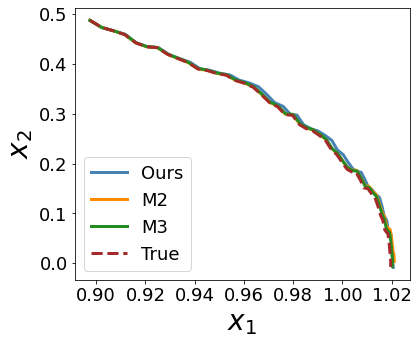

In [97]:
plt.figure(figsize=(6,5))
plt.plot(data_pred_list_pk[:,0], data_pred_list_pk[:,1], label='Ours', color='steelblue', linewidth=3)
plt.plot(data_pred_list_linear[:,0], data_pred_list_linear[:,1], label='M2', color='darkorange', linewidth=3)
plt.plot(data_pred_list_bilinear[:,0], data_pred_list_bilinear[:,1], label='M3', color='forestgreen', linewidth=3)
plt.plot(data_true[:,0], data_true[:,1], label='True', color='brown', linestyle='dashed', linewidth=3)
plt.xlabel(r'$x_{1}$', fontsize=28)
plt.ylabel(r'$x_{2}$', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

In [98]:
data_pred_list_pk_group = np.asarray(data_pred_list_pk_group)
data_pred_list_linear_group = np.asarray(data_pred_list_linear_group)
data_pred_list_bilinear_group = np.asarray(data_pred_list_bilinear_group)
data_true_group = np.asarray(data_true_group)

/tmp/ipykernel_2744432/547857739.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,5))


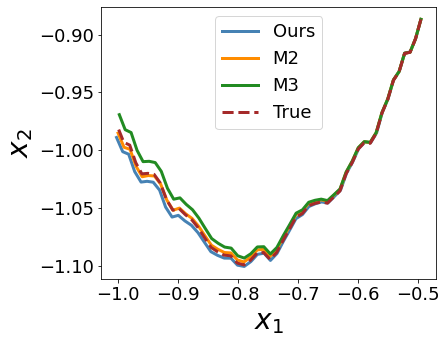

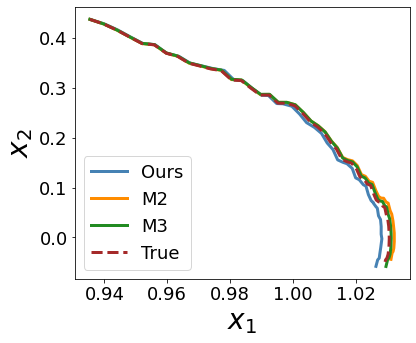

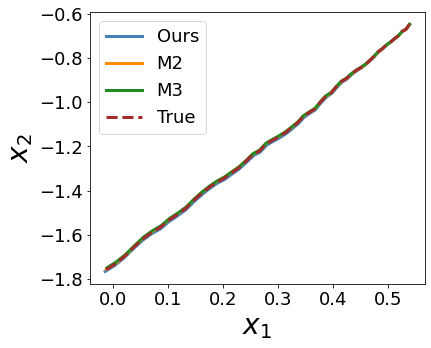

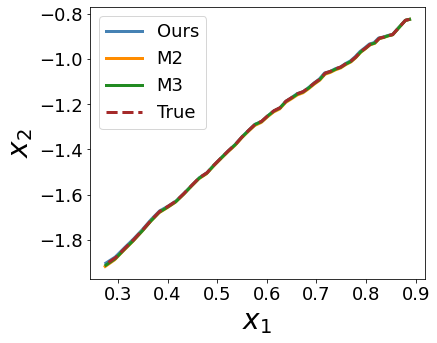

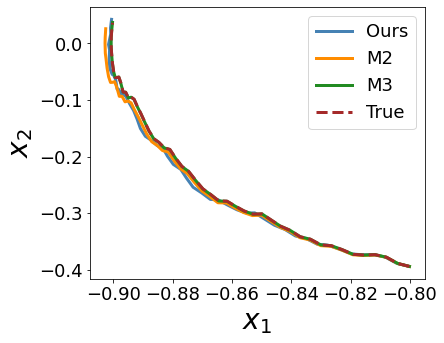

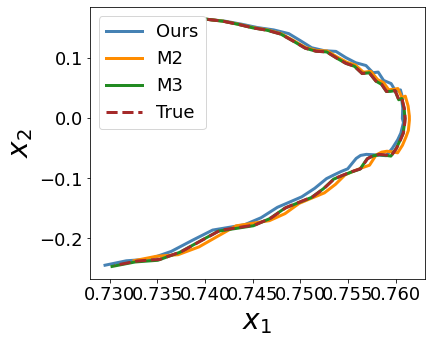

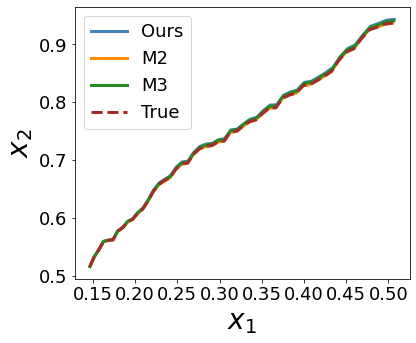

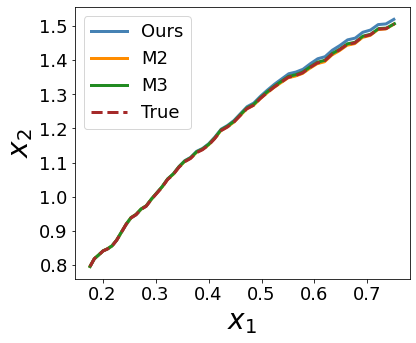

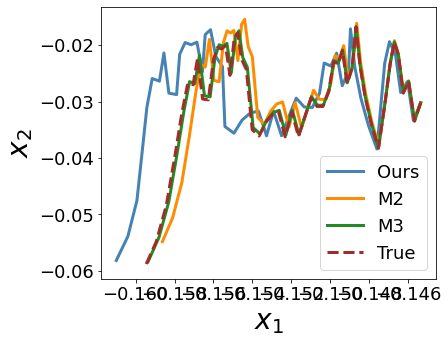

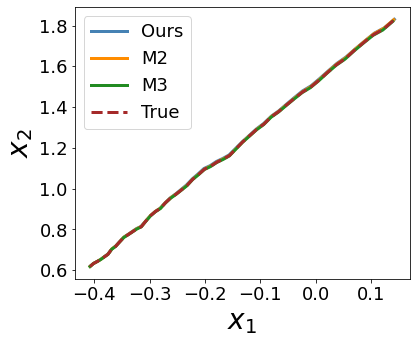

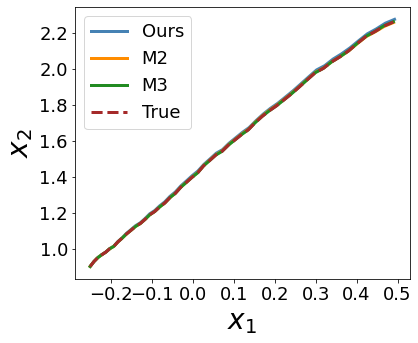

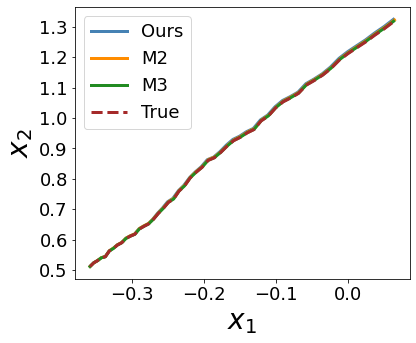

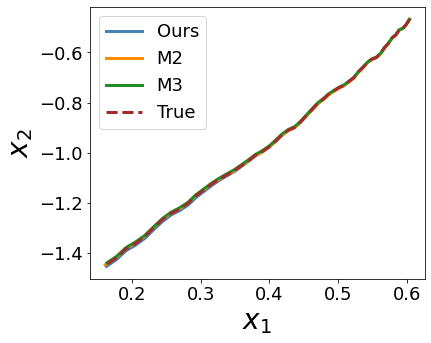

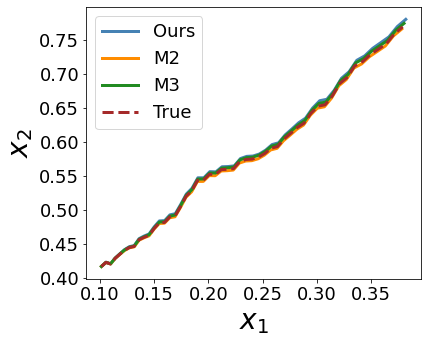

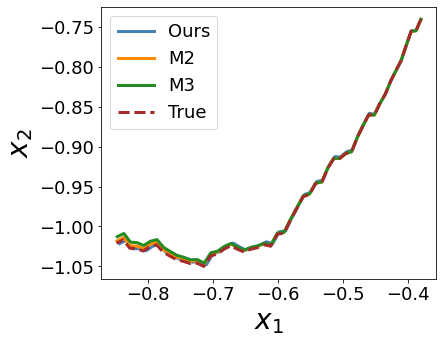

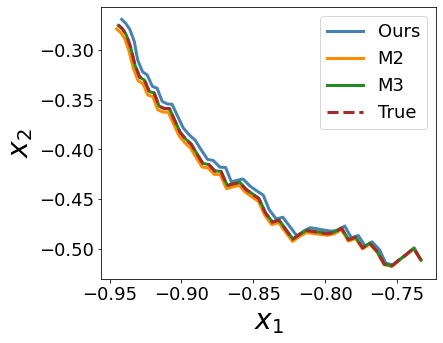

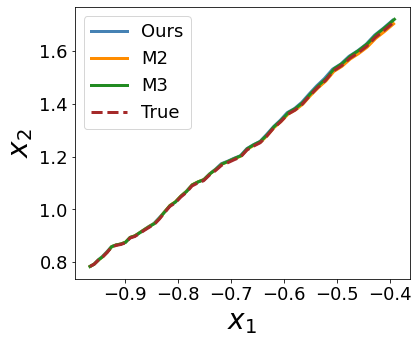

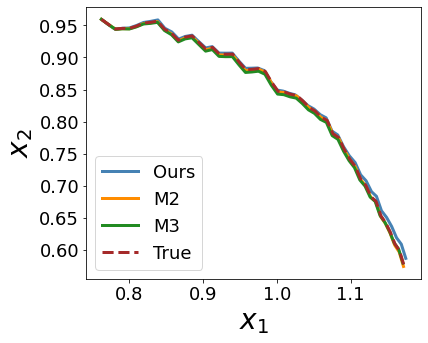

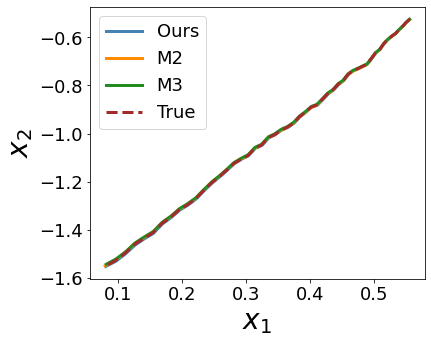

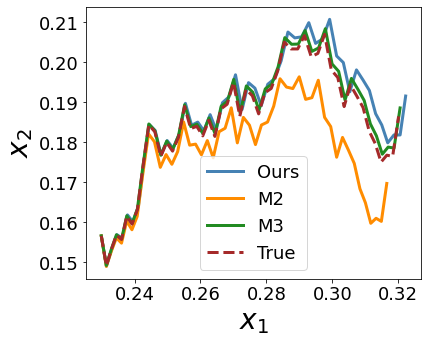

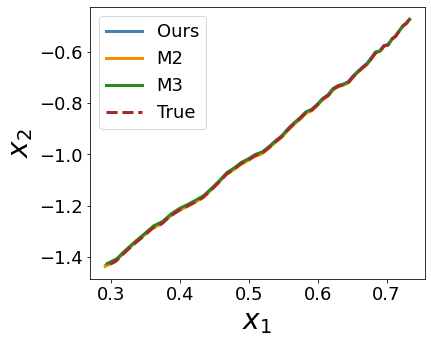

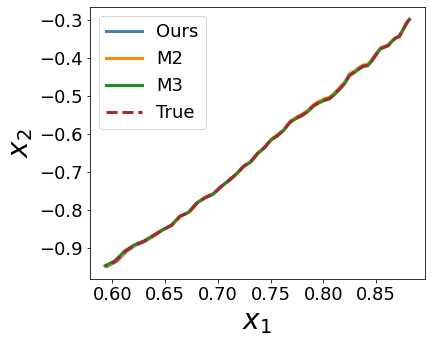

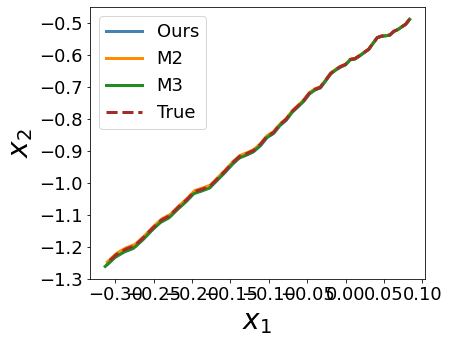

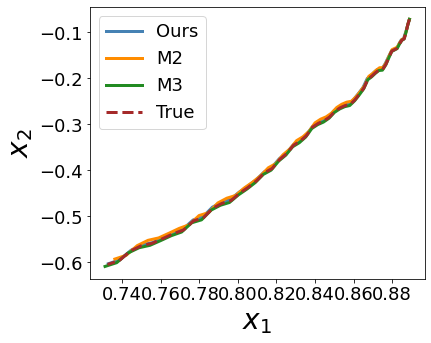

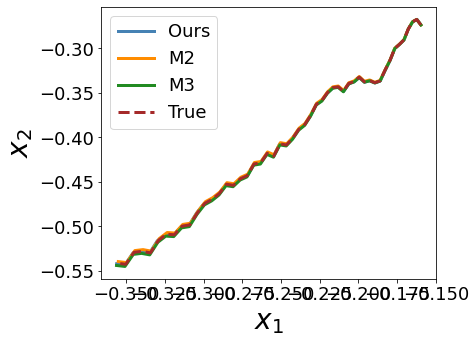

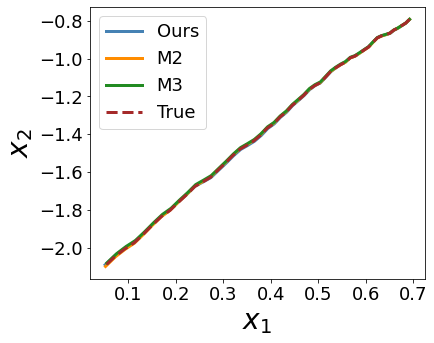

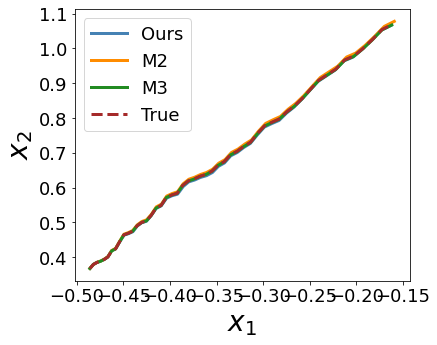

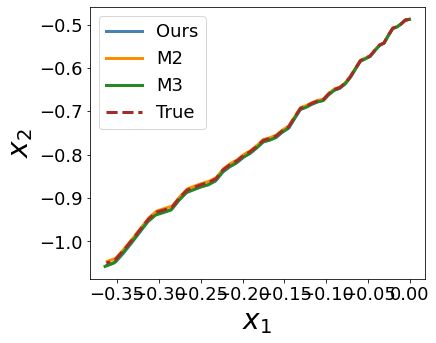

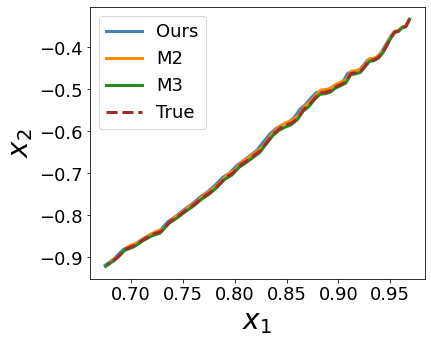

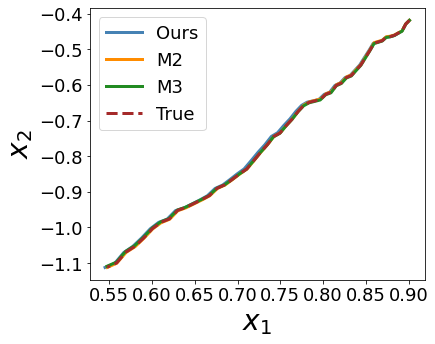

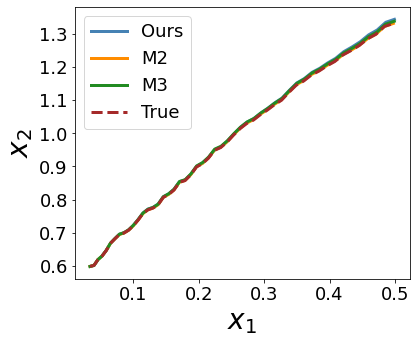

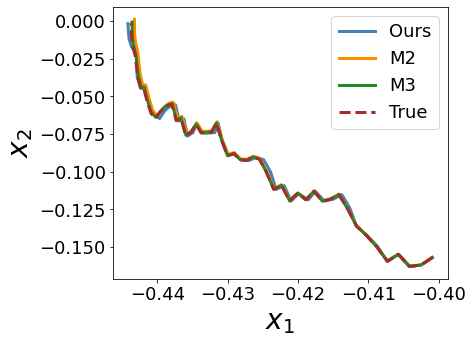

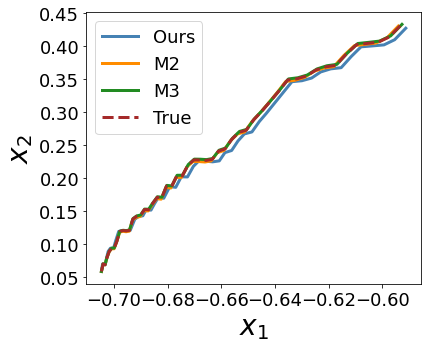

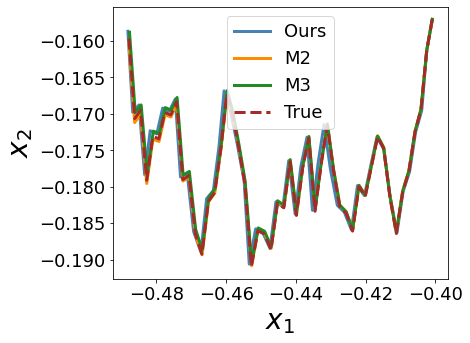

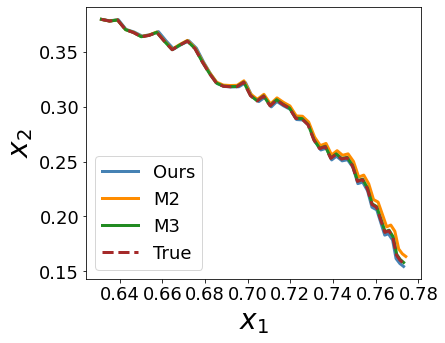

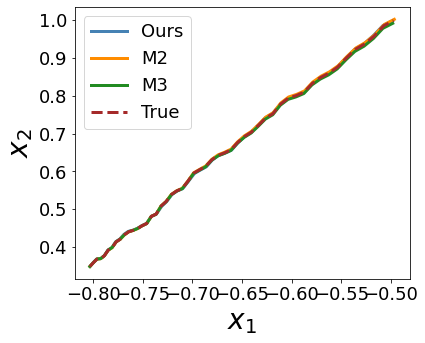

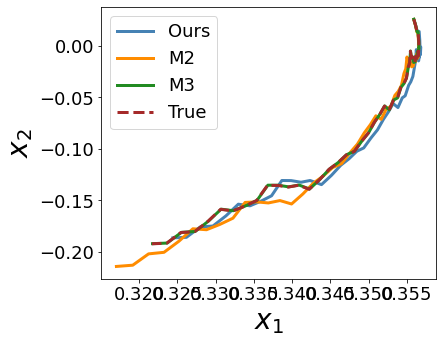

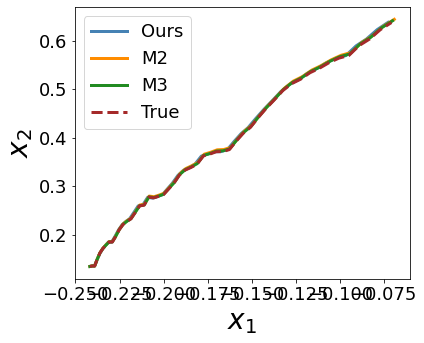

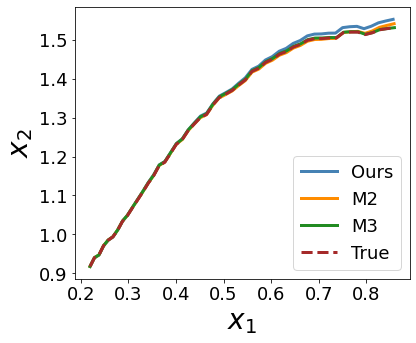

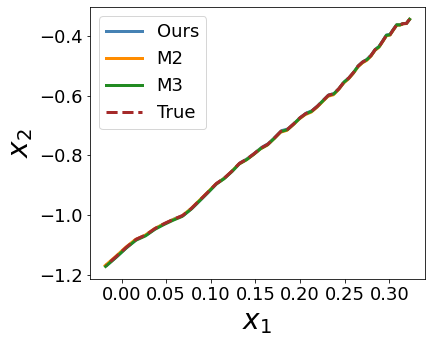

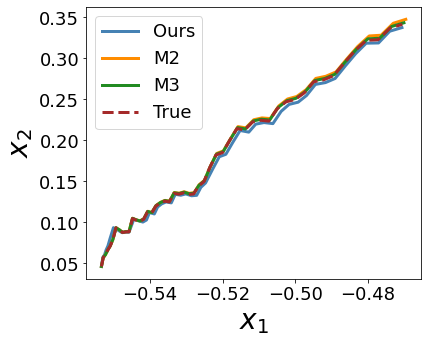

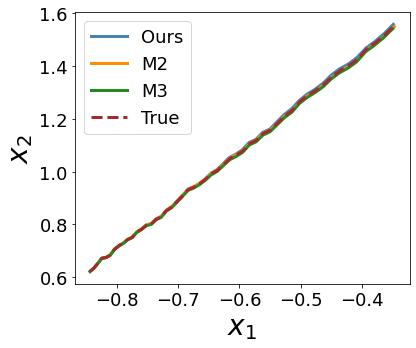

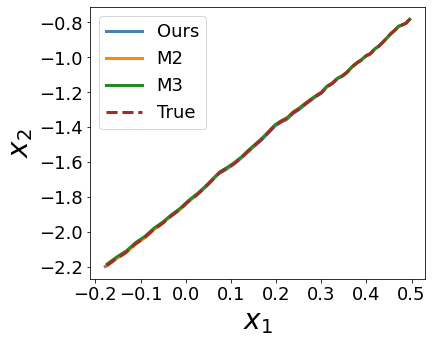

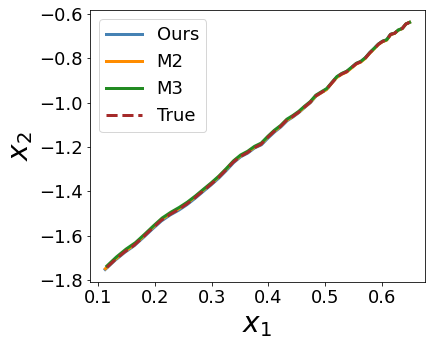

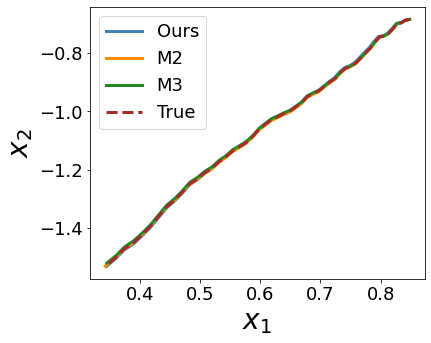

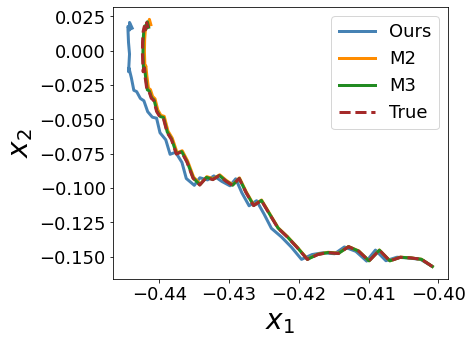

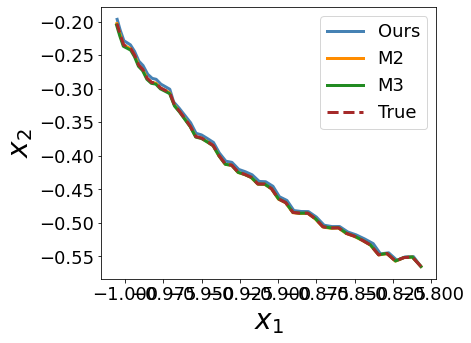

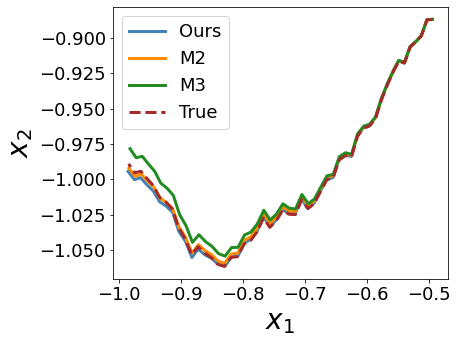

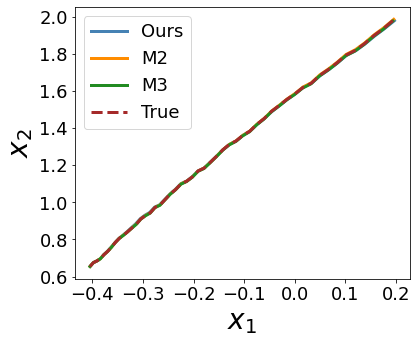

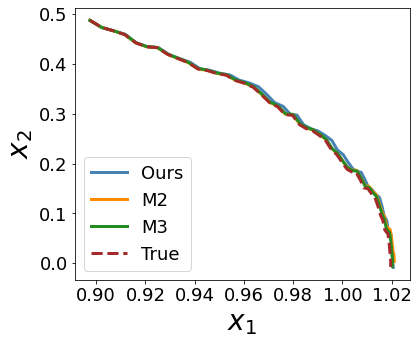

In [99]:
for i in range(data_pred_list_pk_group.shape[0]):
    plt.figure(figsize=(6,5))
    plt.plot(data_pred_list_pk_group[i,:,0], data_pred_list_pk_group[i,:,1], label='Ours', color='steelblue', linewidth=3)
    plt.plot(data_pred_list_linear_group[i,:,0], data_pred_list_linear_group[i,:,1], label='M2', color='darkorange', linewidth=3)
    plt.plot(data_pred_list_bilinear_group[i,:,0], data_pred_list_bilinear_group[i,:,1], label='M3', color='forestgreen', linewidth=3)
    plt.plot(data_true_group[i,:,0], data_true_group[i,:,1], label='True', color='brown', linestyle='dashed', linewidth=3)
    plt.xlabel(r'$x_{1}$', fontsize=28)
    plt.ylabel(r'$x_{2}$', fontsize=28)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)

In [100]:
ratio_pk_list = np.asarray(ratio_pk_list)
ratio_linear_list = np.asarray(ratio_linear_list)
ratio_bilinear_list = np.asarray(ratio_bilinear_list)

In [101]:
ratio_pk_list_mean = np.mean(ratio_pk_list, axis=0)
ratio_linear_list_mean = np.mean(ratio_linear_list, axis=0)
ratio_bilinear_list_mean = np.mean(ratio_bilinear_list, axis=0)

In [102]:
ratio_pk_list_median = np.median(ratio_pk_list, axis=0)
ratio_linear_list_median = np.median(ratio_linear_list, axis=0)
ratio_bilinear_list_median = np.median(ratio_bilinear_list, axis=0)

In [103]:
q_min = 0.35
q_max = 0.65

In [104]:
ratio_pk_list

array([[0.00000000e+00, 1.99512338e-04, 2.27779461e-04, ...,
        2.74190934e-03, 2.86204626e-03, 2.99545817e-03],
       [0.00000000e+00, 2.18196372e-04, 2.95524028e-04, ...,
        1.65693376e-03, 1.67694461e-03, 1.69678176e-03],
       [0.00000000e+00, 7.43121391e-05, 8.57800805e-05, ...,
        3.18835983e-03, 3.22822858e-03, 3.26114398e-03],
       ...,
       [0.00000000e+00, 2.41704042e-04, 2.84525077e-04, ...,
        1.24577266e-03, 1.35267001e-03, 1.46742995e-03],
       [0.00000000e+00, 1.51560488e-04, 1.37007249e-04, ...,
        9.54157062e-04, 9.61404524e-04, 1.01605429e-03],
       [0.00000000e+00, 1.86647900e-04, 1.72126602e-04, ...,
        1.71450736e-03, 1.70902659e-03, 1.70506778e-03]])

In [105]:
ratio_pk_list_min = np.quantile(ratio_pk_list, q=q_min, axis=0)
ratio_linear_list_min = np.quantile(ratio_linear_list, q=q_min, axis=0)
ratio_bilinear_list_min = np.quantile(ratio_bilinear_list, q=q_min, axis=0)

In [106]:
ratio_pk_list_max = np.quantile(ratio_pk_list, q=q_max, axis=0)
ratio_linear_list_max = np.quantile(ratio_linear_list, q=q_max, axis=0)
ratio_bilinear_list_max = np.quantile(ratio_bilinear_list, q=q_max, axis=0)

In [107]:
x_axis = np.arange(0,traj_len_test,1)

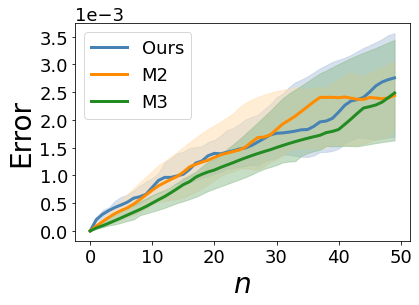

In [108]:
plt.figure(figsize=(6,4))

plt.plot(ratio_pk_list_median, label='Ours', color='steelblue', linewidth=3)
plt.fill_between(x_axis, ratio_pk_list_min, ratio_pk_list_max, color='lightsteelblue', alpha=0.5)
plt.plot(ratio_linear_list_median, label='M2', color='darkorange', linewidth=3)
plt.fill_between(x_axis, ratio_linear_list_min, ratio_linear_list_max, color='navajowhite', alpha=0.5)
plt.plot(ratio_bilinear_list_median, label='M3', color='forestgreen', linewidth=3)
plt.fill_between(x_axis, ratio_bilinear_list_min, ratio_bilinear_list_max, color='darkseagreen', alpha=0.5)


plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_fontsize(18)

plt.xlabel(r'$n$', fontsize=28)
plt.ylabel('Error', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)


In [71]:
dict_mean = {'pk': ratio_pk_list_mean,
              'linear': ratio_linear_list_mean,
              'bilinear': ratio_bilinear_list_mean}

In [51]:
np.save(os.path.join(data_path, 'ratio_list_dict_mu_'+str(mu)+'_mean.npy'), dict_mean)

# See the comparison
If you have tested on all $\mu: 0,1,2,3,4$, then you can run the following codes to see the comparison.

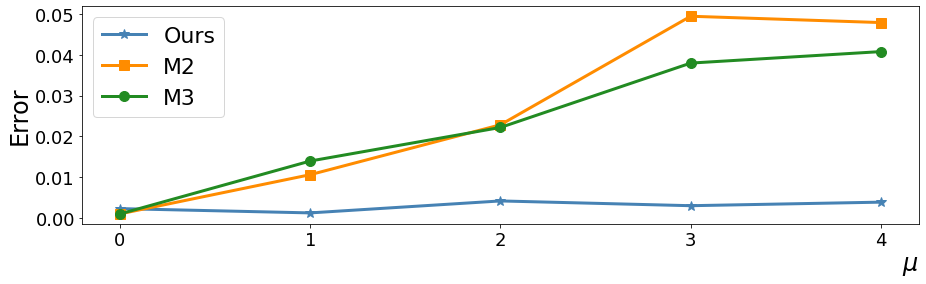

In [53]:
import numpy as np

import matplotlib.pyplot as plt

mean_dict_mu_0 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_0_mean.npy'), allow_pickle=True)
mean_dict_mu_1 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_1_mean.npy'), allow_pickle=True)
mean_dict_mu_2 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_2_mean.npy'), allow_pickle=True)
mean_dict_mu_3 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_3_mean.npy'), allow_pickle=True)
mean_dict_mu_4 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_4_mean.npy'), allow_pickle=True)

def extact_data(ratio_dict, ratio_name):
    ratio_pk = ratio_dict[()][ratio_name[0]].reshape((1,-1))
    ratio_linear = ratio_dict[()][ratio_name[1]].reshape((1,-1))
    ratio_bilinear = ratio_dict[()][ratio_name[2]].reshape((1,-1))
    return ratio_pk, ratio_linear, ratio_bilinear

mean_dict_list = [mean_dict_mu_0, mean_dict_mu_1, mean_dict_mu_2, mean_dict_mu_3, mean_dict_mu_4]

ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []

ratio_name_list = ['pk', 'linear', 'bilinear']

def concat_ratio_list(ratio_list):
    ratio_concat = np.concatenate(ratio_list, axis=0)
    ratio_concat = ratio_concat.T
    return ratio_concat

def concat_data(dict_list):
    pk_list=[]
    linear_list = []
    bilinear_list = []

    for i in range(5):
        pk, linear, bilinear = extact_data(dict_list[i], ratio_name=ratio_name_list)
        pk_list.append(pk)
        linear_list.append(linear)
        bilinear_list.append(bilinear)
        
    pk_concat = concat_ratio_list(pk_list)
    linear_concat = concat_ratio_list(linear_list)
    bilinear_concat = concat_ratio_list(bilinear_list)
    
    return pk_concat, linear_concat, bilinear_concat

mean_pk, mean_linear, mean_bilinear = concat_data(mean_dict_list)

mean_linear_mean = np.mean(mean_linear, axis=0)
mean_bilinear_mean = np.mean(mean_bilinear, axis=0)
mean_pk_mean = np.mean(mean_pk, axis=0)

mu = [0,1,2,3,4]
mu_axis = list(range(len(mu)))


def plot_evaluate_vdpm(mu, mean, dict_plot):
    plt.plot(mu,
             mean,
             label=dict_plot['label'],
             marker=dict_plot['marker'], 
             markersize=dict_plot['markersize'], 
             color=dict_plot['color'],
             linestyle=dict_plot['linestyle'],
             linewidth=dict_plot['linewidth'])

label_font = 24
ticks_font = 18
legend_font = 22






dict_plot_pk = {'label':'Ours',
                'marker':'*',
                'markersize':10,
                'color':'steelblue',
                'linestyle':'-',
                'linewidth':3
               }

dict_plot_linear = {'label':'M2',
                'marker':'s',
                'markersize':10,
                'color':'darkorange',
                'linestyle':'-',
                'linewidth':3
               }

dict_plot_bilinear = {'label':'M3',
                'marker':'o',
                'markersize':10,
                'color':'forestgreen',
                'linestyle':'-',
                'linewidth':3
               }

plt.figure(figsize=(15,4))
plot_evaluate_vdpm(mu, mean_pk_mean, dict_plot=dict_plot_pk)
plot_evaluate_vdpm(mu, mean_linear_mean, dict_plot=dict_plot_linear)

plot_evaluate_vdpm(mu, mean_bilinear_mean, dict_plot=dict_plot_bilinear)

plt.xlabel(r'$\mu$', loc='right', fontsize=label_font)
plt.ylabel('Error', fontsize=label_font)
plt.xticks(mu_axis, mu, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.legend(fontsize=legend_font)
